In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
df=pd.read_csv('Google_Stock_Price_Train.csv',index_col='Date',usecols=['Date','Open'],parse_dates=True)

In [34]:
df.head()

Open
Date              
2012-01-03  325.25
2012-01-04  331.27
2012-01-05  329.83
2012-01-06  328.34
2012-01-09  322.04

In [35]:
df1=pd.read_csv('Google_Stock_Price_Test.csv',usecols=['Date','Open'],index_col='Date',parse_dates=True)

In [36]:
len(df),len(df1),df.shape

(1258, 20, (1258, 1))

In [37]:
type(df1),df1.shape

(pandas.core.frame.DataFrame, (20, 1))

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
scaler=MinMaxScaler()

In [41]:
df[:-60]  ###remove the last 60 data which will use for validation

Open
Date              
2012-01-03  325.25
2012-01-04  331.27
2012-01-05  329.83
2012-01-06  328.34
2012-01-09  322.04
...            ...
2016-09-29  781.44
2016-09-30  776.33
2016-10-03  774.25
2016-10-04  776.03
2016-10-05  779.31

[1198 rows x 1 columns]

In [42]:
X_train_scaled=scaler.fit_transform(df[:-60])

In [43]:
X_train_scaled.shape

(1198, 1)

In [44]:
X_test=df[-60:]  ###take the last 60 for validation

In [45]:
len(X_test)

60

In [46]:
X_test_scaled=scaler.transform(X_test)

In [61]:
X_train_scaled.shape

(1198, 1)

In [32]:
# X_train=[]
# y_train=[]

### Creating a data structure with 60 timesteps and 1 output

In [33]:
# for i in range(60,1258):
#     X_train.append(X_train_scaled[i-60:i,0])
#     y_train.append(X_train_scaled[i])

In [34]:
# X_train,y_train=np.array(X_train),np.array(y_train)

In [42]:
# X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],1))

In [48]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [104]:
generator=TimeseriesGenerator(X_train_scaled,X_train_scaled,length=59,batch_size=1)

validator=TimeseriesGenerator(X_test_scaled,X_test_scaled,length=59,batch_size=1)

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [106]:
model= Sequential()

In [107]:
model.add(LSTM(50,return_sequences=True,input_shape=(59,1)))   ##length, features
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

In [108]:
model.compile(optimizer='adam',loss='mse')  ##metrics=['mae']

In [109]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [110]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 59, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 59, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 59, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 59, 50)            0         
                                                                 
 lstm_16 (LSTM)              (None, 59, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 59, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 50)               

In [111]:
model.fit(generator,validation_data=validator,epochs=100,batch_size=32,callbacks=[early_stop])

Epoch 1/100
 200/1139 [====>.........................] - ETA: 2:24 - loss: 0.0192

KeyboardInterrupt: 

In [77]:
model.save('rnn_model.h5')

C:\Users\mrsna\anaconda3\envs\py_tf\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [78]:
df_loss=pd.DataFrame(model.history.history)

<Axes: >

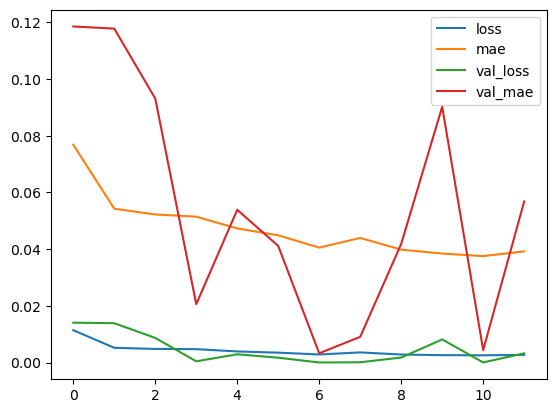

In [79]:
df_loss.plot()

In [81]:
df_test=pd.concat([df[-59:],df1],axis=0)

In [82]:
df_test.shape,type(df_test)

((79, 1), pandas.core.frame.DataFrame)

In [83]:
X_test=scaler.transform(df_test)

In [84]:
generator_test=TimeseriesGenerator(X_test,X_test,length=59,batch_size=1)

In [90]:
x,y=generator_test[19]

In [91]:
scaler.inverse_transform(y)

array([[796.86]])

In [93]:
len(generator_test)

20

In [94]:
x.shape,y.shape

((1, 59, 1), (1, 1))

In [95]:
predictions=model.predict(generator_test)

20/20 [==============================] - 5s 33ms/step


In [97]:
prediction_test=scaler.inverse_transform(predictions)

In [98]:
prediction_test.shape

(20, 1)

In [102]:
df1['predictions']=prediction_test

<Axes: xlabel='Date'>

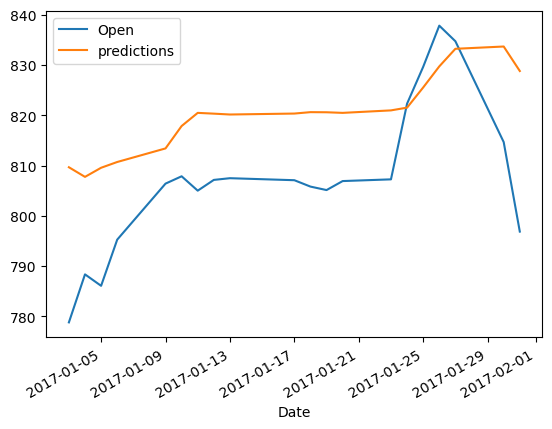

In [103]:
df1.plot()